In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# Show matplotlib plots inline
%matplotlib inline
bases_dir = "season_1_data"

# Load the data path
TRAIN_DATA_DIR = "season_1_data/training_data"
TEST_DATA_DIR = "season_1_data/test_data"

# All the data dirs
CLUSTER_MAP_SHEET_DIR = "cluster_map"
ORDER_SHEET_DIR = "order_data"
TRAFFIC_SHEET_DIR = "traffic_data"
WEATHER_SHEET_DIR = "weather_data"
POI_SHEET_DIR = "poi_data"

### MAPE

In [2]:
from sklearn.utils import assert_all_finite
def MAPE(y_pred, y_true):
    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)
    assert_all_finite(y_true)
    assert_all_finite(y_pred)
    #Filter zero values in y_true
    sel = (y_true != 0)
    y_true = y_true[sel]
    y_pred = y_pred[sel]
    
    return np.mean(np.abs((y_true - y_pred) / y_true))

### Standard Indexing 

In [110]:
# build one standard time slots index in each distric_id
# district_id: 66, date: 21 + 5, time_slots = 144 
train_std_index = pd.DataFrame()
time_slot_index = []
id_index = []
date_index = []
week_index = []
for date, i_date in train_order.groupby('date'):
    for i_id in range(1,67):
        for i_slot in range(1,145):
            time_slot_index.append(int(i_slot))
            id_index.append(i_id)
            date_index.append(date)
            
train_std_index['district_id'] =  id_index
train_std_index['time'] = time_slot_index
train_std_index['date'] = date_index
train_std_index['week'] = pd.to_datetime(train_std_index.date).map(lambda x: x.isoweekday())

train_std_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199584 entries, 0 to 199583
Data columns (total 4 columns):
district_id    199584 non-null int64
time           199584 non-null int64
date           199584 non-null object
week           199584 non-null int64
dtypes: int64(3), object(1)
memory usage: 6.1+ MB


In [114]:
# build one standard time slots index in each distric_id
# district_id: 66, time_slots = 144 
std_index = pd.DataFrame()
time_slot_index = []
id_index = []

for i_id in range(1,67):
    for i_slot in range(1,145):
        time_slot_index.append(int(i_slot))
        id_index.append(i_id)
      
std_index['district_id'] =  id_index
std_index['time'] = time_slot_index

std_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504 entries, 0 to 9503
Data columns (total 2 columns):
district_id    9504 non-null int64
time           9504 non-null int64
dtypes: int64(2)
memory usage: 148.6 KB


In [115]:
# build one standard time slots index in each distric_id
# time_slots = 144 
std_time_index = pd.DataFrame()
time_slot_index = []

for i_slot in range(1,145):
    time_slot_index.append(int(i_slot))

std_time_index['time'] = time_slot_index

std_time_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 1 columns):
time    144 non-null int64
dtypes: int64(1)
memory usage: 1.2 KB


### Order Data Analysis

In [3]:
import glob

# Load all the order data as train_order and test_order
train_order_path = os.path.join(TRAIN_DATA_DIR, ORDER_SHEET_DIR)
test_order_path = os.path.join(TEST_DATA_DIR, ORDER_SHEET_DIR)

train_order_files = glob.glob(os.path.join(train_order_path, "*.csv"))
test_order_files = glob.glob(os.path.join(test_order_path, "*.csv"))

train_order = pd.concat((pd.read_csv(f) for f in train_order_files))
test_order = pd.concat((pd.read_csv(f) for f in test_order_files))

In [138]:
train_order[:2]

,district_id,date,week,time,demand,supply,gap
0,1,2016-01-01,5,1,187,178,9
1,1,2016-01-01,5,2,198,191,7


In [4]:
# Load all the weather data as train_weather and test_weather
train_weather_path = os.path.join(TRAIN_DATA_DIR, WEATHER_SHEET_DIR)
test_weather_path = os.path.join(TEST_DATA_DIR, WEATHER_SHEET_DIR)

train_weather_files = glob.glob(os.path.join(train_weather_path, "*.csv"))
test_weather_files = glob.glob(os.path.join(test_weather_path, "*.csv"))

train_weather = pd.concat((pd.read_csv(f) for f in train_weather_files))
test_weather = pd.concat((pd.read_csv(f) for f in test_weather_files))

In [156]:
weather_temp = pd.read_csv(os.path.join(train_weather_path, 'weather_data_2016-01-21.csv'))
weather_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 6 columns):
Weather        47 non-null int64
temperature    47 non-null float64
PM2.5          47 non-null int64
week           47 non-null int64
date           47 non-null object
time           47 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ KB


In [157]:
group_temp2 = weather_temp.groupby(['date', 'week', 'time']).max().reset_index()
group_temp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 6 columns):
date           37 non-null object
week           37 non-null int64
time           37 non-null int64
Weather        37 non-null int64
temperature    37 non-null float64
PM2.5          37 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.8+ KB


In [159]:
group_temp2[:5]

,date,week,time,Weather,temperature,PM2.5
0,2016-01-21,4,43,4,1.0,49
1,2016-01-21,4,44,4,1.0,49
2,2016-01-21,4,46,4,1.0,49
3,2016-01-21,4,48,4,1.0,50
4,2016-01-21,4,50,4,1.0,50


In [164]:
std_index1 = pd.DataFrame()
time_slot_index = []
id_index = []
date_index = []
week_index = []
for date, i_date in group_temp2.groupby('date'):
    for i_slot in range(1,145):
        time_slot_index.append(int(i_slot))
        date_index.append(date)
            

std_index1['time'] = time_slot_index
std_index1['date'] = date_index
std_index1['week'] = pd.to_datetime(std_index1.date).map(lambda x: x.isoweekday())

std_index1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
time    144 non-null int64
date    144 non-null object
week    144 non-null int64
dtypes: int64(2), object(1)
memory usage: 3.4+ KB


In [165]:
std_index1[:2]

,time,date,week
0,1,2016-01-21,4
1,2,2016-01-21,4


In [166]:
full_weather = std_index1.merge(group_temp2, on=['time', 'date', 'week'], how='left')
full_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 6 columns):
time           144 non-null int64
date           144 non-null object
week           144 non-null int64
Weather        37 non-null float64
temperature    37 non-null float64
PM2.5          37 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 7.9+ KB


In [168]:
#Interpolate
full_weather['PM2.5'] = full_weather['PM2.5'].interpolate(method='nearest')
full_weather['date'] = full_weather['date'].interpolate(method='nearest')
full_weather['week'] = full_weather['week'].interpolate(method='nearest')
full_weather['Weather'] = full_weather['Weather'].interpolate(method='nearest')
full_weather['temperature'] = full_weather['temperature'].interpolate(method='nearest')
# date format can not be interpolated, it can be solved wi

full_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 6 columns):
time           144 non-null int64
date           144 non-null object
week           144 non-null int64
Weather        102 non-null float64
temperature    102 non-null float64
PM2.5          102 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 7.9+ KB


In [172]:
full_weather[35:45]

,time,date,week,Weather,temperature,PM2.5
35,36,2016-01-21,4,NaN,NaN,NaN
36,37,2016-01-21,4,NaN,NaN,NaN
37,38,2016-01-21,4,NaN,NaN,NaN
38,39,2016-01-21,4,NaN,NaN,NaN
39,40,2016-01-21,4,NaN,NaN,NaN
40,41,2016-01-21,4,NaN,NaN,NaN
41,42,2016-01-21,4,NaN,NaN,NaN
42,43,2016-01-21,4,4.0,1.0,49.0
43,44,2016-01-21,4,4.0,1.0,49.0
44,45,2016-01-21,4,4.0,1.0,49.0


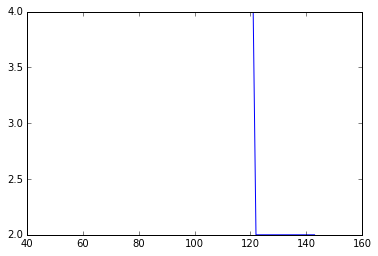

In [176]:
plt.figure()
plt.plot(full_weather.Weather, label=str(date))

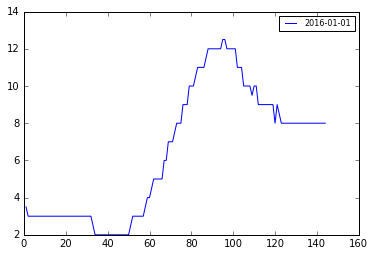

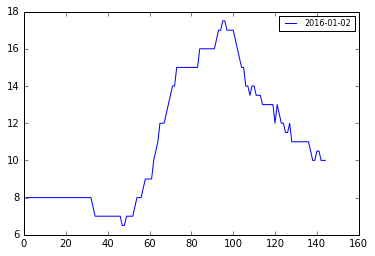

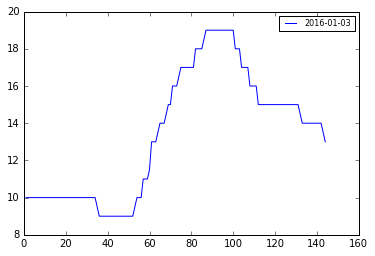

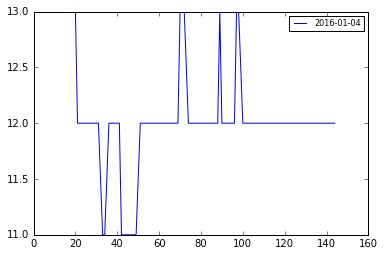

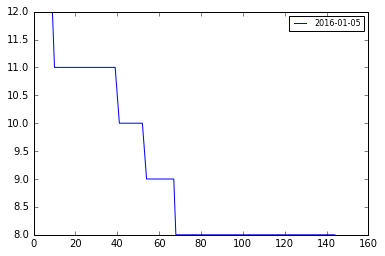

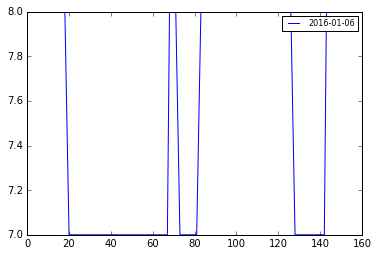

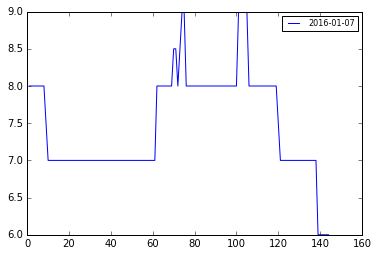

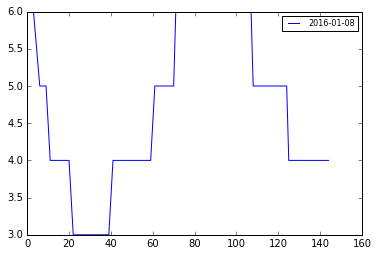

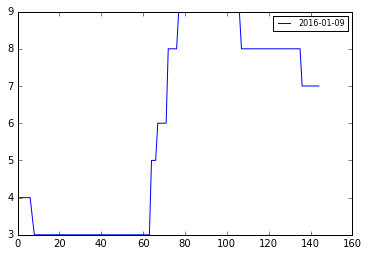

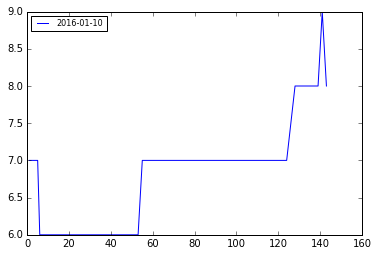

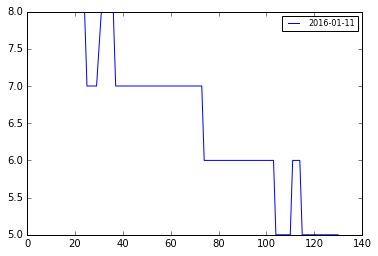

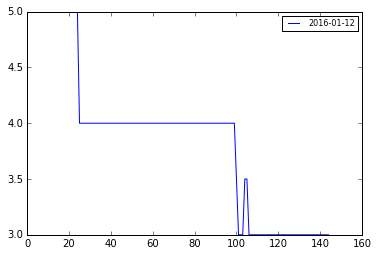

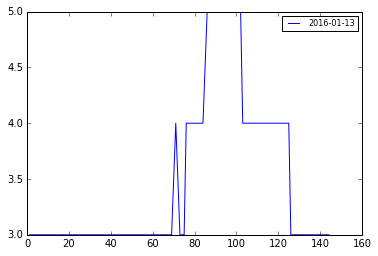

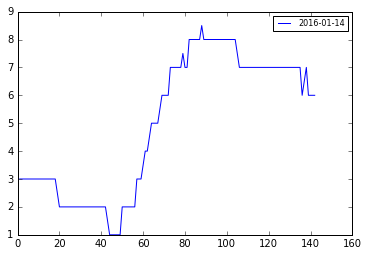

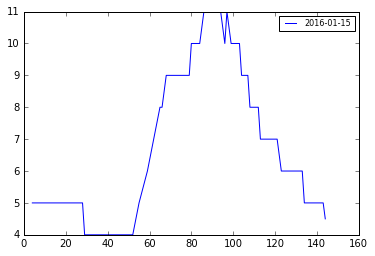

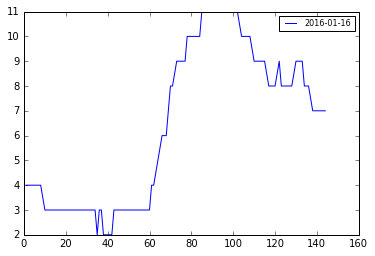

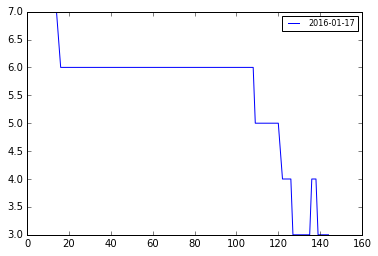

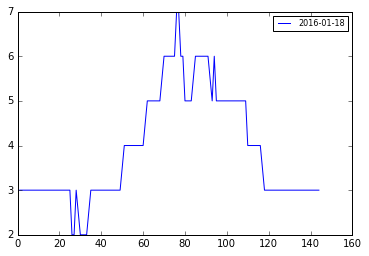

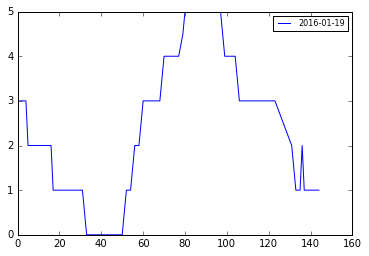

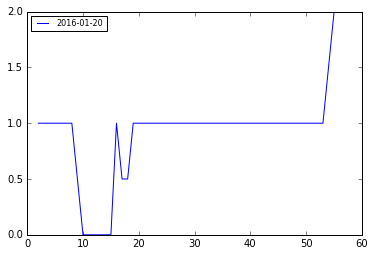

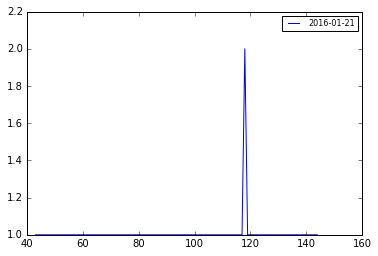

In [181]:
for date, drp in train_weather.groupby('date'):
    plt.figure()
    plt.plot(drp.groupby('time').temperature.mean(), label=str(date))
    plt.legend(loc=0,prop={'size':8})

In [ ]:
for date, drp in train_weather.groupby('date'):
    
    #plt.figure()
    #for date, dgr in wgr.groupby('date'):
    ##    plt.plot(dgr.groupby('time').demand.mean(), label=str(date))
    #plt.title('demand')
    #plt.legend(loc=2,prop={'size':8})
    
    plt.figure()
    for date, dgr in wgr.groupby('date'):
        plt.plot(dgr.groupby('time').gap.mean(), label=str(date))
    plt.title('gap')
    plt.legend(loc=2,prop={'size':8})
    
    

In [98]:
train_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4811 entries, 0 to 46
Data columns (total 6 columns):
Weather        4811 non-null int64
temperature    4811 non-null float64
PM2.5          4811 non-null int64
week           4811 non-null int64
date           4811 non-null object
time           4811 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 263.1+ KB


In [73]:
train_weather[:5]

,Weather,temperature,PM2.5,week,date,time
0,1,4.0,177,5,2016-01-01,1
1,1,3.0,177,5,2016-01-01,1
2,1,3.0,177,5,2016-01-01,2
3,1,3.0,177,5,2016-01-01,2
4,1,3.0,177,5,2016-01-01,3


In [107]:
group_temp = train_weather.groupby(['date', 'week', 'time']).max().reset_index()
group_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2670 entries, 0 to 2669
Data columns (total 6 columns):
date           2670 non-null object
week           2670 non-null int64
time           2670 non-null int64
Weather        2670 non-null int64
temperature    2670 non-null float64
PM2.5          2670 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 125.2+ KB


In [109]:
group_temp[:10]

,date,week,time,Weather,temperature,PM2.5
0,2016-01-01,5,1,1,4.0,177
1,2016-01-01,5,2,1,3.0,177
2,2016-01-01,5,3,1,3.0,177
3,2016-01-01,5,4,1,3.0,177
4,2016-01-01,5,5,1,3.0,177
5,2016-01-01,5,6,1,3.0,177
6,2016-01-01,5,7,1,3.0,177
7,2016-01-01,5,8,1,3.0,177
8,2016-01-01,5,9,1,3.0,177
9,2016-01-01,5,10,1,3.0,177


In [71]:
# Load all the poi data
train_poi_path = os.path.join(TRAIN_DATA_DIR, POI_SHEET_DIR)
test_poi_path = os.path.join(TEST_DATA_DIR, POI_SHEET_DIR)

train_poi_files = glob.glob(os.path.join(train_poi_path, "*.csv"))
test_poi_files = glob.glob(os.path.join(test_poi_path, "*.csv"))

train_poi = pd.concat((pd.read_csv(f) for f in train_poi_files))
test_poi = pd.concat((pd.read_csv(f) for f in test_poi_files))

In [72]:
train_poi[:2]

,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,...,25_1,25_2,25_3,25_4,25_5,25_6,25_7,25_8,25_9,district_id
0,415,2822,498,249,12367,83,166,4316,166,249,...,0,0,581,0,249,415,4980,1909,6142,12
1,332,83,0,166,0,249,83,332,0,0,...,0,0,0,0,0,83,249,0,83,43


In [82]:
# Load all the traffic data
train_traffic_path = os.path.join(TRAIN_DATA_DIR, TRAFFIC_SHEET_DIR)
test_traffic_path = os.path.join(TEST_DATA_DIR, TRAFFIC_SHEET_DIR)

train_traffic_files = glob.glob(os.path.join(train_traffic_path, "*.csv"))
test_traffic_files = glob.glob(os.path.join(test_traffic_path, "*.csv"))

train_traffic = pd.concat((pd.read_csv(f) for f in train_traffic_files))
test_traffic = pd.concat((pd.read_csv(f) for f in test_traffic_files))

In [83]:
train_traffic[:2]

,traffic_1,traffic_2,traffic_3,traffic_4,week,date,time,district_id
0,231,33,13,10,5,2016-01-01,142,66
1,305,69,13,16,5,2016-01-01,56,66


In [84]:
train_traffic.describe()

,traffic_1,traffic_2,traffic_3,traffic_4,week,time,district_id
count,193553.000000,193553.000000,193553.00000,193553.000000,193553.000000,193553.000000,193553.000000
mean,603.522338,128.780282,38.72173,26.097756,4.007672,72.641271,33.197594
std,704.277587,216.896741,67.77862,42.035663,2.005752,41.189142,19.025079
min,0.000000,0.000000,0.00000,0.000000,1.000000,2.000000,1.000000
25%,147.000000,16.000000,5.00000,3.000000,2.000000,37.000000,17.000000
50%,323.000000,49.000000,15.00000,10.000000,4.000000,73.000000,33.000000
75%,779.000000,146.000000,43.00000,30.000000,6.000000,108.000000,49.000000
max,4223.000000,2084.000000,863.00000,486.000000,7.000000,144.000000,66.000000


In [6]:
train_order[['supply', 'gap']] = train_order[['supply', 'gap']].astype(int)
train_order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163491 entries, 0 to 7904
Data columns (total 7 columns):
district_id    163491 non-null int64
date           163491 non-null object
week           163491 non-null int64
time           163491 non-null int64
demand         163491 non-null int64
supply         163491 non-null int32
gap            163491 non-null int32
dtypes: int32(2), int64(4), object(1)
memory usage: 8.7+ MB


In [7]:
for date, drp in train_order.groupby('date'):
    print len(drp.time) / 66.

124.681818182
118.409090909
117.712121212
116.53030303
115.742424242
115.893939394
115.757575758
117.106060606
117.53030303
118.090909091
117.106060606
116.636363636
116.863636364
115.96969697
117.651515152
119.848484848
120.075757576
118.242424242
118.803030303
118.712121212
119.772727273


**Results:** There are many time slots missing. fill interpolation into these empty slots.

- The empty slots should be found first. build a standard time slots index in each district_id to compare with them.

In [9]:
train_order.describe()

,district_id,week,time,demand,supply,gap
count,163491.000000,163491.000000,163491.000000,163491.000000,163491.000000,163491.000000
mean,31.732909,4.011780,78.289814,52.239047,42.963552,9.275495
std,18.562100,1.999978,39.426369,112.348401,81.039485,49.817422
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,49.000000,4.000000,3.000000,0.000000
50%,31.000000,4.000000,80.000000,12.000000,10.000000,1.000000
75%,47.000000,6.000000,112.000000,47.000000,41.000000,4.000000
max,66.000000,7.000000,144.000000,4362.000000,1084.000000,3872.000000


In [ ]:
train_std_index[160:163]

In [ ]:
train_order[160:163]

In [10]:
import os
full_data = train_std_index.merge(train_order, on=['district_id', 'time', 'week', 'date'], how='left')
#train_order.merge(train_std_index, on=['district_id', 'date', 'time', 'week'], how='left')
#full_data.to_csv('fulldata.csv')

In [ ]:
full_data[160:165]

In [ ]:
full_data.describe()

In [11]:
# Interpolation between missing time slots.
full_data.demand = full_data.demand.interpolate()
full_data.supply = full_data.supply.interpolate()
full_data.gap = full_data.gap.interpolate()

In [ ]:
full_data[160:170]
#temp.to_csv('fulldata1.csv')

In [ ]:
full_data.describe()

In [ ]:
test_order.describe()

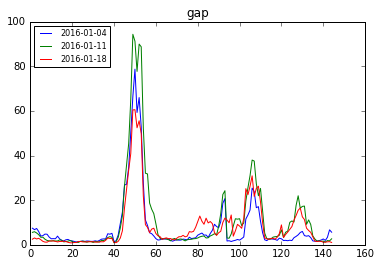

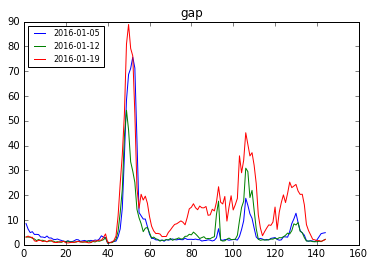

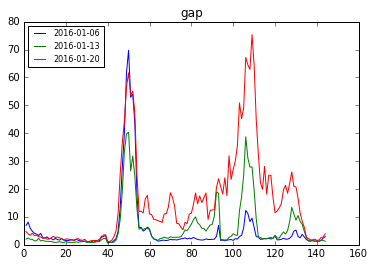

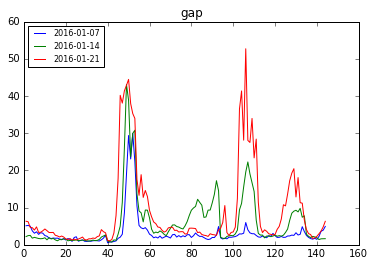

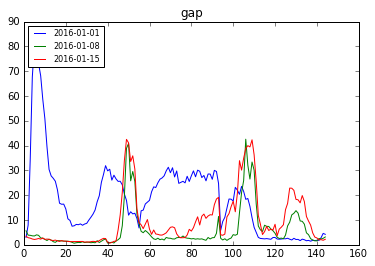

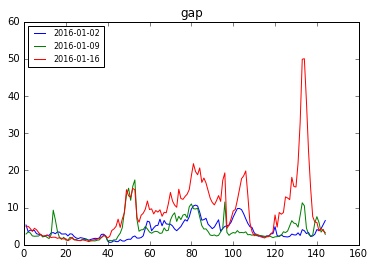

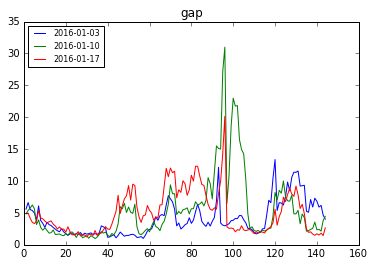

In [12]:
for work, wgr in full_data.groupby('week'):
    
    #plt.figure()
    #for date, dgr in wgr.groupby('date'):
    ##    plt.plot(dgr.groupby('time').demand.mean(), label=str(date))
    #plt.title('demand')
    #plt.legend(loc=2,prop={'size':8})
    
    plt.figure()
    for date, dgr in wgr.groupby('date'):
        plt.plot(dgr.groupby('time').gap.mean(), label=str(date))
    plt.title('gap')
    plt.legend(loc=2,prop={'size':8})

### The data analysis 
- New Year's day holiday (Jan. 1-3). Jan. 3 is normal, Jan.1-2 delete

### Select data after 2016-01-02

In [13]:
order_data_selected = full_data[full_data.date > '2016-01-07']
order_data_selected[:2]

,district_id,time,date,week,demand,supply,gap
66528,1,1,2016-01-08,5,76.0,72.0,4.0
66529,1,2,2016-01-08,5,51.0,50.0,1.0


#### Calculate gap mean in each time slot

In [14]:
grouped_temp1 = order_data_selected.groupby(['district_id','week', 'time']).mean()
data_average_gap = grouped_temp1.reset_index()
data_average_gap.describe()

,district_id,week,time,demand,supply,gap
count,66528.000000,66528.000000,66528.000000,66528.000000,66528.000000,66528.000000
mean,33.500000,4.000000,72.500000,45.005073,36.874079,8.130994
std,19.050515,2.000015,41.568529,103.738700,76.763244,38.428352
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,17.000000,2.000000,36.750000,2.166667,1.500000,0.500000
50%,33.500000,4.000000,72.500000,8.000000,6.500000,1.000000
75%,50.000000,6.000000,108.250000,33.500000,29.000000,3.000000
max,66.000000,7.000000,144.000000,1489.000000,802.500000,995.500000


In [15]:
data_average_gap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66528 entries, 0 to 66527
Data columns (total 6 columns):
district_id    66528 non-null int64
week           66528 non-null int64
time           66528 non-null int64
demand         66528 non-null float64
supply         66528 non-null float64
gap            66528 non-null float64
dtypes: float64(3), int64(3)
memory usage: 3.0 MB


### Test file 

In [16]:
# Load test.csv
test_data = pd.read_csv('season_1/test.csv', header= None)
test_data.columns = ["district_id", "Time","gap"]
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 3 columns):
district_id    2838 non-null int64
Time           2838 non-null object
gap            2838 non-null int64
dtypes: int64(2), object(1)
memory usage: 66.6+ KB


In [17]:
test_date =  test_data.Time.map(lambda x: x[:10])
test_time_slice = pd.to_datetime(test_date, unit='s')

test_data["week"] = test_time_slice.map(lambda x: x.isoweekday())
test_data["date"] = test_time_slice.map(lambda x: x.date())
test_data["time"] = test_data.Time.map(lambda x: x[11:]).map(int)

del test_data["gap"]
del test_data["Time"]
test_data[:2]

,district_id,week,date,time
0,1,5,2016-01-22,46
1,2,5,2016-01-22,46


In [ ]:
test_data.info()

In [ ]:
test_order[:2]

In [18]:
gap_true_0604 = test_order['gap']

In [19]:
gap_true_0604[:2]

0    4.0
1    1.0
Name: gap, dtype: float64

In [20]:
test_0603 = test_order.merge(data_average_gap, on = ['district_id','week', 'time'], how='left' )

In [21]:
test_0603[:2]

,district_id,date,week,time,demand_x,supply_x,gap_x,demand_y,supply_y,gap_y
0,1,2016-01-22,5,43,74,70.0,4.0,75.5,74.5,1.0
1,1,2016-01-22,5,44,128,127.0,1.0,113.5,112.0,1.5


In [22]:
gap_pred_0604 = test_0603['gap_y']
gap_pred_0604[:2]

0    1.0
1    1.5
Name: gap_y, dtype: float64

In [23]:
MAPE(gap_pred_0604,gap_true_0604)

0.79385519497606971

### Predict the gap based on average gap

In [24]:
result = test_data.merge(data_average_gap, on = ['district_id','week', 'time'], how='left' )
result[:2]

,district_id,week,date,time,demand,supply,gap
0,1,5,2016-01-22,46,215.5,211.5,4.0
1,2,5,2016-01-22,46,26.5,26.0,0.5


In [25]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2838 entries, 0 to 2837
Data columns (total 7 columns):
district_id    2838 non-null int64
week           2838 non-null int64
date           2838 non-null object
time           2838 non-null int64
demand         2838 non-null float64
supply         2838 non-null float64
gap            2838 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 177.4+ KB


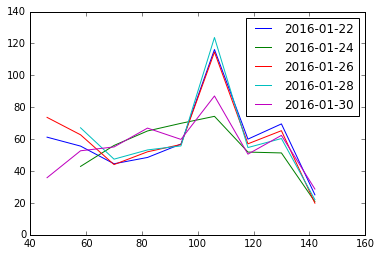

In [26]:
for date, drp in result.groupby('date'):
    plt.plot(drp.groupby('time').demand.mean(), label=str(date))
plt.legend()

In [27]:
# Reformat to meet the submit format
result['Time'] = result['date'].map(str) + '-' + result['time'].map(str)
result_data = result.loc[:, ['district_id', 'Time', 'gap']]
result_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2838 entries, 0 to 2837
Data columns (total 3 columns):
district_id    2838 non-null int64
Time           2838 non-null object
gap            2838 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 88.7+ KB


In [28]:
# Cehck
result_data[160:165]

,district_id,Time,gap
160,29,2016-01-22-70,3.0
161,30,2016-01-22-70,0.5
162,31,2016-01-22-70,1.5
163,32,2016-01-22-70,0.0
164,33,2016-01-22-70,1.5


In [29]:
# The prediction result output as *.csv
result_data.to_csv('result0606.csv', index=False, header=False)

## Predicted by regressor

In [ ]:
full_data = full_data.drop('date',axis = 1)
full_data[:2]

In [ ]:
order_data_selected = order_data_selected.drop('date',axis = 1)

In [ ]:
full_data.values[:,0:6]

In [ ]:
full_data.info()

In [ ]:
test_order.info()

In [ ]:
test_order[:2]

In [ ]:
#test_order = test_order.drop('date', axis =1)

#test_order = test_order.reindex(['district_id', 'week', 'time', 'date', 'demand', 'supply', 'gap'])
test_order1 = test_order.loc[:,['district_id', 'week', 'time','date', 'demand', 'supply', 'gap']]
test_order1[:2]

In [ ]:
full_data[:2]

In [ ]:
#full_data = order_data_selected.loc[:,['district_id', 'week', 'time','date', 'demand', 'supply', 'gap']]
#full_data[:2]

In [ ]:
#train_data = order_data_selected.loc[:,['district_id', 'week', 'time','date', 'demand', 'supply', 'gap']]
#train_data[:2]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100, max_depth= 3)
clf.fit(order_data_selected.values[:,0:3], order_data_selected.values[:,5])

In [ ]:
from sklearn.tree import DecisionTreeRegressor
clf1 = DecisionTreeRegressor(max_depth = 10)
clf1.fit(order_data_selected.values[:,0:3], order_data_selected.values[:,5])

In [ ]:
from sklearn import svm
clf2 = svm.SVR()
clf2.fit(order_data_selected.values[:,0:3], order_data_selected.values[:,5])

In [ ]:
gap_pred = clf.predict(test_order1.values[:,0:3])
gap_true = test_order1.values[:,6]

MAPE(gap_pred, gap_true)

In [ ]:
gap_pred[:2]

In [ ]:
#test_temp = test_data.drop('date',axis=1)
test_temp[:2]

In [ ]:
result_pred = clf.predict(test_temp.values)

In [ ]:
result_pred.shape

In [ ]:
test_data[:2]

In [ ]:
test_data['gap'] = result_pred 

In [ ]:
test_data[:2]

In [ ]:
for date, drp in test_data.groupby('date'):
    plt.plot(drp.groupby('time').gap.mean(), label=str(date))
plt.legend()

In [ ]:
# Reformat to meet the submit format
test_data['Time'] = test_data['date'].map(str) + '-' + test_data['time'].map(str)
result_data = test_data.loc[:, ['district_id', 'Time', 'gap']]
result_data.info()

In [30]:
#check
result_data[:2]

,district_id,Time,gap
0,1,2016-01-22-46,4.0
1,2,2016-01-22-46,0.5


In [ ]:
# The prediction result output as *.csv
result_data.to_csv('result0605.csv', index=False, header=False)

In [40]:
size = result_data.shape[0]
vals = np.random.choice(size, size/100, replace=False)
vals

array([2760, 1031, 1169,  904, 2204, 1062,  493,  669, 1060, 2492, 1053,
       1080,  301,  534, 1205,  761, 1406,  790, 2708, 2695, 1270, 1607,
        891, 2205,  718, 2237,   97,  437])

In [53]:
n = len(full_data)
cols = list(set(full_data.index[1:n+1].intersection(result_data.columns).difference(['gap','week'])))
cols

[]

In [56]:
full_data[cols]

""
0
1
2
3
4
5
6
7
8
9


In [55]:
X = np.array(full_data[cols])
X[:2]

array([], shape=(2L, 0L), dtype=float64)

In [44]:
trains = list(set(xrange(size)).difference(vals))
#trains

In [45]:
result_data.columns

Index([u'district_id', u'Time', u'gap'], dtype='object')

In [ ]:
def train_val_split(X, y, index):
    train, val = [], []
    np.random.seed(5150)
    size = y.shape[0]
    vals = np.random.choice(size, size/100, replace=False)
    trains = list(set(xrange(size)).difference(vals))
    return X[trains, :], X[vals, :], y[trains], y[vals], index[trains, :], index[vals, :]

In [ ]:
n=len(pareto)

cols = (list(set(pareto.index[1:n+1]).intersection(test_data.columns)
                                   .difference(['y', 'district_ID', 'UTC', 'Interval'])))

X = np.array(training_data[cols])
y = np.array(training_data['y'])
index = np.array(training_data[['district_ID', 'UTC']]) #convert to np.array temporarily

X_train, X_val, y_train, y_val, _, index_vals = train_val_split(X, y, index)

index_val = pd.DataFrame(index_vals, columns=['district_ID', 'UTC'])

X_test = np.array(test_data[cols])
index_test = test_data[['district_ID', 'Interval']] #keep as pandas

### Traffic Data Analysis

In [86]:
import glob

train_traffic_path = os.path.join(TRAIN_DATA_DIR, TRAFFIC_SHEET_DIR)
test_traffic_path = os.path.join(TEST_DATA_DIR, TRAFFIC_SHEET_DIR)

train_traffic_files = glob.glob(os.path.join(train_traffic_path, "*.csv"))
test_traffic_files = glob.glob(os.path.join(test_traffic_path, "*.csv"))

# Load all the order data as train_order and test_order
train_traffic = pd.concat((pd.read_csv(f) for f in train_traffic_files))
test_traffic = pd.concat((pd.read_csv(f) for f in test_traffic_files))

ValueError: No objects to concatenate

In [ ]:
train_traffic.head()